QVAPOR OK
TH2 OK
Viento OK


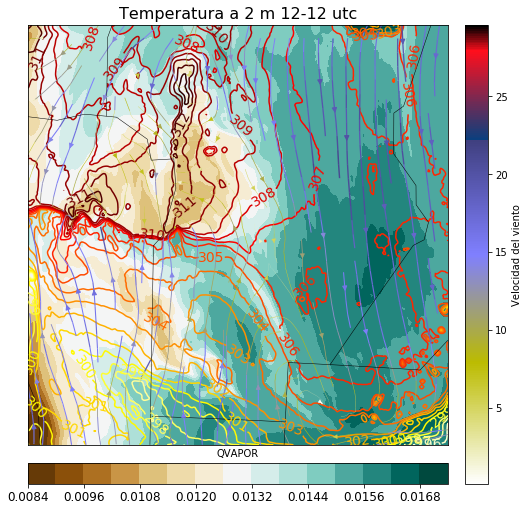

In [106]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

from matplotlib.colors import LightSource

import cartopy.crs as crs
import cartopy._crs as _ccrs

from matplotlib.cm import get_cmap
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy,get_basemap, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import wrf



def mapa_somb_cont2(path = '../../../../media/agustin/Linux/salidas_wrf/test01/',
                   archivo = 'wrfout_d02_2018-11-10_12:00:00',
                   var_s = '0',  ts = 0,   lev_s = 0  , us = 0 , cmap_s = 'coolwarm', 
                   var_c1 = '0', tc1 = -1, lev_c1 = 0 , uc1 = 0, cmap_c1 = 0,
                   var_c2 = '0', tc2 = -1, lev_c2 = 0 , uc2 = 0, cmap_2 = 0,
                   viento = False, lev_viento = 0,sep_barb = 1,viento_cmap = 'Blues',
                   titulo = 'Sin titulo definido', guardar = False,
                   topografia = True, topo_mode = 'soft'
                   ):
    
    """CARGA DE DATOS"""
    data = Dataset(path+archivo,'r')

    lats, lons, topo = getvar(data,'XLAT'), getvar(data,'XLONG'), np.asarray(getvar(data,'HGT'))
    
    bm = get_basemap(lats)

    
    if tc1 == -1: tc1 = ts
    if tc2 == -1: tc2 = ts
    if lev_c1 == -1: lev_c1 = lev_s
    if lev_c2 == -1: lev_c2 = lev_s
    
    ks,kc1,kc2,   = 1, 1, 1
    n_var_s, n_var_c1, n_var_c2 = var_s, var_c1, var_c2
    lozada = [-31.651943,-64.07947]

    
    for i in ts:
        """""""""SOMBREADO"""""""""
        if n_var_s != '0':
            if (type (n_var_s)== str) and (type(i) == int):
                print(n_var_s + ' OK')
                
                var_s = getvar(data,n_var_s, timeidx = i)#, units = us)# if type(us)==str else None)
                
                if len (var_s.shape)>2: var_s = var_s[lev_s,...]
                smooth_var_s = smooth2d(var_s, 3, cenweight=4)
                bm, somb = get_basemap(var_s), True
    
            else:
                print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                      Si no escribis ts por default es 0 \033[0m""")
                return 0
        else: somb = False
        """"""""""""""""""""""""""""""""
        """""""""CONTORNO 1"""""""""
        if n_var_c1 != '0':
            if (type(n_var_c1) == str) and (type(i) == int):
                print(n_var_c1 +' OK')
                var_c1 = getvar(data,n_var_c1,timeidx= i)#, units = uc1 if type(uc1)==str else None)
                
                if len (var_c1.shape)>2: var_c1 = var_c1[lev_c1,...]
                smooth_var_c1 = smooth2d(var_c1, 3, cenweight=4)
                lats, lons = latlon_coords(var_c1)          
                bm, cont1 = get_basemap(var_c1), True

            else: 
                print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                      Si no escribis tc1 por default es 0 \033[0m""")
                return 0
        else: cont1 = False
        """"""""""""""""""""""""""
        """""""""CONTORNO 2"""""""""
        if n_var_c2 != '0':
            if (type(n_var_c2)== str) and (type(i) == int):
                print(n_var_c2 + ' OK')

                var_c2 = getvar(data,n_var_c2,timeidx=i)#, units = uc2 if type(uc2)==str else None)
                
                if len (var_c2.shape)>2: var_c2 = var_c2[lev_c2,...]
                smooth_var_c2, cont2 = smooth2d(var_c2, 3, cenweight=4), True
                bm = get_basemap(var_c2)
            else: 
                print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                      Si no escribis tc2 por default es 0 \033[0m""")
                return 0
        else: cont2 = False
        """"""""""""""""""""""""""    
        """""""""VIENTO"""""""""
        if viento == True:
            print('Viento OK')
            a=sep_barb  
            v_x = getvar(data,'U', timeidx= i )[lev_viento,...]
            v_y = getvar(data, 'V', timeidx= i) [lev_viento,...]
        
        """"""""""""""""""""""""""        
        if topografia == True: 
            print('Topografía OK')
            dx = 111200*np.asarray(data.variables['XLONG'][0,:,0])*np.cos(np.radians(np.min(topo)))
            dy = 111200*np.asarray(data.variables['XLAT'][0,0,:])
            ls = LightSource(azdeg=315, altdeg=45)
            cmap2 = plt.cm.gist_earth
            ve = 1



    
        """""""""ACA EMPIEZA EL MAPA"""""""""
        # DEINO DIA Y HORA
        l=i%24
        d=int(i/24)+12 
        
        fig, ax = plt.subplots(1,figsize = (10,7))

        x, y = bm(to_np(lons), to_np(lats))
        """""""""""""""GRAFICO SOMBREADO"""""""""""""""
        if somb == True:
            if len(smooth_var_s.shape) == 3: var_s = to_np(smooth_var_s[i,...])
            else: var_s = to_np(smooth_var_s)

            ps = ax.contourf(x, y, var_s,15 , cmap = plt.get_cmap(cmap_s))
            cbar = bm.colorbar(ps, location = 'bottom', shrink=1, pad = 0.25) 
            cbar.ax.tick_params(labelsize=12, labelbottom = True , labelright = False)
            
            plt.xlabel(n_var_s)

            
            ###TOPOGRAFÍA EN CONTORNO###
            if topografia == True: bm.contour(x,y, topo,cmap = 'gray')
        """"""""""""""""""""""""""""""""""""""""""""""""""
        """""""""TOPOGRAFÍA EN SOMBREADO SI NO HAY CONTOURF"""""""""
        if topografia == True:
            top = ls.hillshade(topo, vert_exag=ve, dx=dx, dy=dy)
            bm.imshow(top, cmap='gray')
            rgb = ls.shade(topo, cmap=plt.get_cmap('Greys'), blend_mode=topo_mode,
                           vert_exag=ve, dx=dx, dy=dy)
            bm.imshow(rgb)
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""GRAFICO CONTORNO 1"""""""""""""""""""""
        if cont1 == True:
            
            if len(smooth_var_c1.shape) == 3: var_c1 = to_np(smooth_var_c1[i,...])
            else: var_c1 = to_np(smooth_var_c1)

            c1_min, c1_max, ncont_1 =np.min(var_c1),np.max(var_c1), 20

            clev=np.linspace(c1_min,c1_max,ncont_1)
            pc1 = bm.contour(x,y, var_c1,clev, cmap = plt.get_cmap(cmap_c1))
            clab = plt.clabel(pc1,clev,fontsize=14,fmt='%.00f')
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""GRAFICO CONTORNO 2"""""""""""""""""""""
        if cont2 == True:
            
            if len(smooth_var_c2.shape) == 3: var_c2 = to_np(smooth_var_c2[i,...])
            else: var_c2 = to_np(smooth_var_c2)
            pc2 = ax.contour(x,y, var_c2) 
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""GRAFICO VIENTO"""""""""""""""""""""
        if viento == True:
            
            x_v = x[0,:]
            y_v = y[:,0]

            v_x = to_np(v_x[:,:-1])
            v_y = to_np(v_y[:-1,:])
            
            speed = np.sqrt((v_x*2) ** 2 + (v_y*2) ** 2)
            lw = 2*speed / speed.max()

            vi= bm.streamplot(y_v, x_v, v_x, v_y, color = speed, density = 1
                            ,cmap = plt.get_cmap(viento_cmap) , linewidth= lw)
            
            cbar_v = plt.colorbar(vi.lines,shrink = 1, pad = -0.2)
            
            cbar_v.ax.set_ylabel('Velocidad del viento')
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""BASEMAP"""""""""""""""""""""""""""""""""""""""""""""
        bm.drawcoastlines(linewidth=0.25)
        bm.drawstates(linewidth=0.5)
        bm.drawcountries(linewidth=0.25)
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""        
        plt.tight_layout()
        plt.title(titulo+" %s-%s utc" %(l,d), fontsize = 16)

        if guardar==True:
            plt.savefig("img/"+titulo+"%s-%sutc" 
                        %(l,d),format='png')
        plt.show()
    data.close()
    
        
mapa_somb_cont2(  var_s = 'QVAPOR',var_c1='TH2',topografia = False, 
                ts = [12],tc1 = 10, titulo='Temperatura a 2 m',
               cmap_s = 'BrBG',cmap_c1='hot_r', viento = True, viento_cmap='gist_stern_r')
               


In [111]:
path = '../../../../media/agustin/Linux/salidas_wrf/test01/'
archivo = 'wrfout_d02_2018-11-10_12:00:00'
data = Dataset(path+archivo,'r')

print(data.variables['THM'])
data.variables.keys()

<class 'netCDF4._netCDF4.Variable'>
float32 THM(Time, bottom_top, south_north, west_east)
    FieldType: 104
    MemoryOrder: XYZ
    description: either 1) pert moist pot temp=(1+Rv/Rd Qv)*(theta)-T0, or 2) pert dry pot temp=t
    units: K
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (48, 59, 305, 305)
filling on, default _FillValue of 9.969209968386869e+36 used



odict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'SHDMAX', 'SHDMIN', 'SNOALB', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'ACSNOM', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'COSZEN', 'LAI', 'DTAUX3D', 'DTAUY3D', 'DUSFCG', 'DVSFCG', 'VAR', 'CON', 'OA1', 'OA2', 'OA3', 'OA4', 'OL1', 'OL2', 'OL3', 'OL4', 'MAPFAC_M', 'MAPFAC_U', 'MAPFAC_V', 'MAPFAC_MX', 'MAPFAC_MY', 'MAPFAC_UX', 'MAPFAC_UY', 'MAPFAC_VX', 'MF_VX_INV', 'MAPFAC_VY', 'F', 'E', 'SINALPHA', 'C

(305,) (305,)
(305, 305)
(305, 305)
(305, 305)
(305, 305)
(305, 305)
(305, 305)


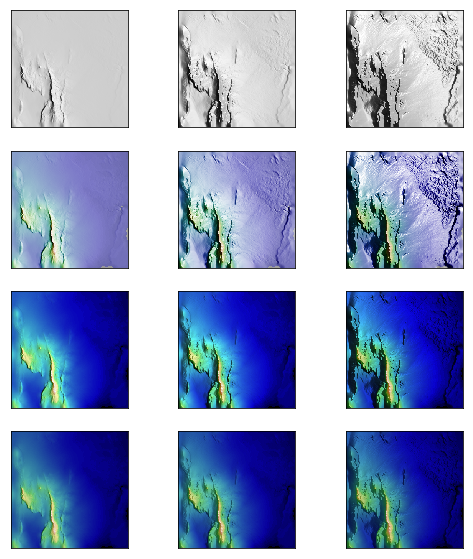

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource


path = '../../../../media/agustin/Linux/salidas_wrf/test01/'
archivo = 'wrfout_d02_2018-11-10_12:00:00'
data = Dataset(path+archivo,'r')

z = np.asarray(data.variables['HGT'][0,...])

#-- Optional dx and dy for accurate vertical exaggeration ----------------
# If you need topographically accurate vertical exaggeration, or you don't
# want to guess at what *vert_exag* should be, you'll need to specify the
# cellsize of the grid (i.e. the *dx* and *dy* parameters).  Otherwise, any
# *vert_exag* value you specify will be relative to the grid spacing of
# your input data (in other words, *dx* and *dy* default to 1.0, and
# *vert_exag* is calculated relative to those parameters).  Similarly, *dx*
# and *dy* are assumed to be in the same units as your input z-values.
# Therefore, we'll need to convert the given dx and dy from decimal degrees
# to meters.
dx, dy = np.asarray(data.variables['XLONG'][0,:,0]), np.asarray(data.variables['XLAT'][0,0,:])
print(dx.shape,dy.shape)
dy = 111200 * dy
dx = 111200 * dx * np.cos(np.radians(np.min(z)))
#-------------------------------------------------------------------------

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 9))
plt.setp(axes.flat, xticks=[], yticks=[])

# Vary vertical exaggeration and blend mode and plot all combinations
for col, ve in zip(axes.T, [0.1, 1, 10]):
    # Show the hillshade intensity image in the first row
    print(z.shape)
    top = ls.hillshade(z, vert_exag=ve, dx=dx, dy=dy)
    print(top.shape)
    col[0].imshow(top, cmap='gray')
    
    # Place hillshaded plots with different blend modes in the rest of the rows
    for ax, mode in zip(col[1:], ['hsv', 'overlay', 'soft']):
        rgb = ls.shade(z, cmap=cmap, blend_mode=mode,
                       vert_exag=ve, dx=dx, dy=dy)
        ax.imshow(rgb)

"""# Label rows and columns
for ax, ve in zip(axes[0], [0.1, 1, 10]):
    ax.set_title('{0}'.format(ve), size=18)
for ax, mode in zip(axes[:, 0], ['Hillshade', 'hsv', 'overlay', 'soft']):
    ax.set_ylabel(mode, size=18)

"""# Group labels...
"""axes[0, 1].annotate('Vertical Exaggeration', (0.5, 1), xytext=(0, 30),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='center', va='bottom', size=20)
axes[2, 0].annotate('Blend Mode', (0, 0.5), xytext=(-30, 0),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='right', va='center', size=20, rotation=90)
"""
fig.subplots_adjust(bottom=0.05, right=0.95)

plt.show()

In [7]:
x,y = m(255,146)
x_,y_ = m(lat,lon)
#plt.subplot2grid((1,2),(0,0))
m.imshow(t[0,10,:,:],cmap=plt.get_cmap('coolwarm'))
m.scatter(146,255)#,s=1000)

#plt.scatter(x,y,marker='o',s=100,color='r')
m.drawparallels(np.arange(minlat,maxlat,5),labels = [0.5,0,0,0], fontsize = 10, linewidth = 0.4)
m.drawmeridians(np.arange(minlon,maxlon,10),labels=[0,0,0,0.3],fontsize = 10, linewidth = 0.4)
m.drawcoastlines(linewidth = 0.6)
m.drawcountries(linewidth = 0.5)
m.drawstates(linewidth = 0.4)
lon_ = lon[0,146]
lat_ = lat[255,0]
x,y = m(lon_, lat_)
loz = m.plot(x, y, 'bo', markersize=24)
#plt.plot(146,255,marker='o',color='r')

plt.show()

NameError: name 'm' is not defined

IndexError: too many indices

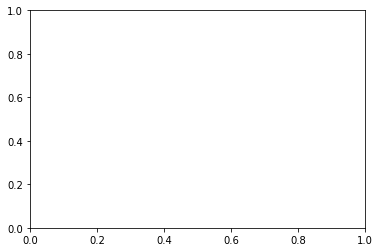

In [120]:
fig ,ax= plt.subplots(1)

dl=2.
[ptlat,ptlon] = [-31.651739700-dl/2.,-64.097784300-dl/2.]
plt.contourf(lon[0,:,:],lat[0,:,:],t[0,0,:,:])
plt.plot([ptlon,ptlon],[ptlat,ptlat+dl],'-k',linewidth=2)
plt.plot([ptlon,ptlon+dl],[ptlat+dl,ptlat+dl],'-k',linewidth=2)
plt.plot([ptlon+dl,ptlon+dl],[ptlat+dl,ptlat],'-k',linewidth=2)
plt.plot([ptlon+dl,ptlon],[ptlat,ptlat],'-k',linewidth=2)
#a= mpach.Rectangle((210,116),40,30,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(a)

plt.show()